In [1]:
"""Load packages"""

import numpy as np
from validation import compute_f1
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from prepro import readfile, createBatches, createMatrices, iterate_minibatches, addCharInformation, padding, readfileAll
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
import random

Using TensorFlow backend.


In [2]:
"""Initialise class"""

class CNN_BLSTM(object):
    
    def __init__(self, PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        self.per = PER
        
    def loadData(self):
        """Load data and add character information"""
        random.seed(420)
        temp = readfile("Annotations_spacy")
        temp1 = random.sample(temp,round(len(temp)*0.2))
        self.testSentences = temp1.copy()
        temp2 = [x for x in temp if x not in self.testSentences]
        if (round(len(temp)*self.per)) > len(temp2):
            count = len(temp2)
        else:
            count = round(len(temp)*self.per)
        temp3 = random.sample(temp2,count)
        self.trainSentences = temp3.copy()
        self.devSentences = self.testSentences
        
#         self.trainSentences = readfile("data/train.txt")
#         self.devSentences = readfile("data/dev.txt")
#         self.testSentences = readfile("data/test.txt")
        
    def addCharInfo(self):
        # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)
        
#         self.trainSentences = addCharInformation(self.trainSentences)
#         self.devSentences = addCharInformation(self.devSentences)
#         self.testSentences = addCharInformation(self.testSentences)

    def embed(self):
        """Create word- and character-level embeddings"""

        labelSet = set()
        words = {}

        # unique words and labels in data  
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:
                    # token ... token, char ... list of chars, label ... BIO labels
                    labelSet.add(label)
                    words[token.lower()] = True

        # mapping for labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # mapping for token cases
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # read GLoVE word embeddings
        word2Idx = {}
        self.wordEmbeddings = []

        fEmbeddings = open("embeddings/glove.6B.50d.txt", encoding="utf-8")

        # loop through each word in embeddings
        for line in fEmbeddings:
            split = line.strip().split(" ")
            word = split[0]  # embedding word entry

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
                self.wordEmbeddings.append(vector)

            if split[0].lower() in words:
                vector = np.array([float(num) for num in split[1:]])
                self.wordEmbeddings.append(vector)  # word embedding vector
                word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

        self.wordEmbeddings = np.array(self.wordEmbeddings)

        # dictionary of all possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
            self.char2Idx[c] = len(self.char2Idx)

        # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        
        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches"""
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        correctLabels = []
        predLabels = []
        for i, data in enumerate(dataset):
            tokens, casing, char, labels = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            pred = model.predict([tokens, casing, char], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # character input
        character_input = Input(shape=(None, 52,), name="Character_input")
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
            character_input)

        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                          trainable=False)(words_input)

        # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                           trainable=False)(casing_input)

        # concat & BLSTM
        output = concatenate([words, casing, char])
        output = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                                   ), name="BLSTM")(output)
        output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)

        # set up model
        self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
#         plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")
        
    def train(self):
        """Default training"""

        self.f1_test_history = []
        self.f1_dev_history = []

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing,char = batch
                self.model.train_on_batch([tokens, casing,char], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("f1 test ", round(f1_test, 4))

            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
            
        print("Training finished.")
            
        # save model
        self.modelName = "{}_{}_{}_{}_{}_{}_{}_{}".format(self.per,
                                                        self.epochs, 
                                                        self.dropout, 
                                                        self.dropout_recurrent, 
                                                        self.lstm_state_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.optimizer.__class__.__name__
                                                       )
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")
        
    def train2(self):
        """New training"""

        self.f1_test_history = []
        self.precision_test_history = 0
        self.recall_test_history = 0
        
        self.f1_dev_history = []
        self.precision_dev_history = 0
        self.recall_dev_history = 0

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing,char = batch
                self.model.train_on_batch([tokens, casing,char], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            self.precision_test_history = pre_test
            self.recall_test_history = rec_test
            print("f1 test ", round(f1_test, 4))

#             predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
#             pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
#             self.f1_dev_history = f1_dev
#             self.precision_dev_history = precision_dev
#             self.recall_dev_history = recall_dev
#             print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
            
        print("Training finished.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")
        

    def writeToFile(self):
        """Write output to file"""

        # .txt file format
        # [epoch  ]
        # [f1_test]
        # [precision_test ]
        # [recall_test]
        
        output = [self.per, " F1: ", self.f1_test_history[-1], " Precision: ", self.precision_test_history, " Recall: ", self.recall_test_history]

        fileName = "result.txt"
        with open(fileName,'a') as f:
            for out in output:
                f.write(str(out))
            f.write("\n")
                
        print("Model performance written to file.")

    print("Class initialised.")

Class initialised.


In [3]:
"""Set parameters"""

PER = 0.1
EPOCHS = 30               # paper: 80
DROPOUT = 0.5             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 200     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended


In [4]:
"""Construct and run model 10% Training Data"""

cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.1111
Epoch 1/30
f1 test  0.2756
Epoch 2/30
f1 test  0.2434
Epoch 3/30
f1 test  0.2947
Epoch 4/30
f1 test  0.3187
Epoch 5/30
f1 test  0.3655
Epoch 6/30
f1 test  0.4206
Epoch 7/30
f1 test  0.4199
Epoch 8/30
f1 test  0.4251
Epoch 9/30
f1 test  0.4444
Epoch 10/30
f1 test  0.5104
Epoch 11/30
f1 test  0.4842
Epoch 12/30
f1 test  0.4972
Epoch 13/30
f1 test  0.4335
Epoch 14/30
f1 test  0.4787
Epoch 15/30
f1 test  0.507
Epoch 16/30
f1 test  0.5104
Epoch 17/30
f1 test  0.5189
Epoch 18/30
f1 test  0.54
Epoch 19/30
f1 test  0.5269
Epoch 20/30
f1 test  0.5314
Epoch 21/30
f1 test  0.5588
Epoch 22/30
f1 test  0.5022
Epoch 23/30
f1 test  0.4742
Epoch 24/30
f1 test  0.4854
Epoch 25/30
f1 test  0.5327
Epoch 26/30
f1 test  0.4667
Epoch 27/30
f1 test  0.5253
Epoch 28/30
f1 test  0.4804
Epoch 29/30
f1 test  0.51
Final F1 test score:  0.51
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 20% Training Data"""
PER = 0.2
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.2404
Epoch 1/30
f1 test  0.1795
Epoch 2/30
f1 test  0.388
Epoch 3/30
f1 test  0.3053
Epoch 4/30
f1 test  0.4585
Epoch 5/30
f1 test  0.5194
Epoch 6/30
f1 test  0.582
Epoch 7/30
f1 test  0.5714
Epoch 8/30
f1 test  0.5541
Epoch 9/30
f1 test  0.5948
Epoch 10/30
f1 test  0.6348
Epoch 11/30
f1 test  0.5603
Epoch 12/30
f1 test  0.5826
Epoch 13/30
f1 test  0.6026
Epoch 14/30
f1 test  0.6009
Epoch 15/30
f1 test  0.6114
Epoch 16/30
f1 test  0.6009
Epoch 17/30
f1 test  0.614
Epoch 18/30
f1 test  0.5673
Epoch 19/30
f1 test  0.6083
Epoch 20/30
f1 test  0.5738
Epoch 21/30
f1 test  0.5592
Epoch 22/30
f1 test  0.6197
Epoch 23/30
f1 test  0.622
Epoch 24/30
f1 test  0.5974
Epoch 25/30
f1 test  0.5752
Epoch 26/30
f1 test  0.5792
Epoch 27/30
f1 test  0.5586
Epoch 28/30
f1 test  0.5727
Epoch 29/30
f1 test  0.5962
Final F1 test score:  0.5961538461538463
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 30% Training Data"""
PER = 0.3
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.2673
Epoch 1/30
f1 test  0.3493
Epoch 2/30
f1 test  0.4854
Epoch 3/30
f1 test  0.5566
Epoch 4/30
f1 test  0.6
Epoch 5/30
f1 test  0.5297
Epoch 6/30
f1 test  0.6017
Epoch 7/30
f1 test  0.5882
Epoch 8/30
f1 test  0.6204
Epoch 9/30
f1 test  0.5975
Epoch 10/30
f1 test  0.566
Epoch 11/30
f1 test  0.5867
Epoch 12/30
f1 test  0.6278
Epoch 13/30
f1 test  0.6352
Epoch 14/30
f1 test  0.5929
Epoch 15/30
f1 test  0.5867
Epoch 16/30
f1 test  0.5551
Epoch 17/30
f1 test  0.5546
Epoch 18/30
f1 test  0.6182
Epoch 19/30
f1 test  0.5648
Epoch 20/30
f1 test  0.6188
Epoch 21/30
f1 test  0.5753
Epoch 22/30
f1 test  0.5742
Epoch 23/30
f1 test  0.599
Epoch 24/30
f1 test  0.604
Epoch 25/30
f1 test  0.619
Epoch 26/30
f1 test  0.5845
Epoch 27/30
f1 test  0.5545
Epoch 28/30
f1 test  0.569
Epoch 29/30
f1 test  0.6009
Final F1 test score:  0.6008583690987125
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 40% Training Data"""
PER = 0.4
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.2587
Epoch 1/30
f1 test  0.37
Epoch 2/30
f1 test  0.4902
Epoch 3/30
f1 test  0.5303
Epoch 4/30
f1 test  0.6195
Epoch 5/30
f1 test  0.5812
Epoch 6/30
f1 test  0.5946
Epoch 7/30
f1 test  0.565
Epoch 8/30
f1 test  0.565
Epoch 9/30
f1 test  0.5575
Epoch 10/30
f1 test  0.6009
Epoch 11/30
f1 test  0.5492
Epoch 12/30
f1 test  0.616
Epoch 13/30
f1 test  0.5714
Epoch 14/30
f1 test  0.57
Epoch 15/30
f1 test  0.6218
Epoch 16/30
f1 test  0.5829
Epoch 17/30
f1 test  0.6083
Epoch 18/30
f1 test  0.5673
Epoch 19/30
f1 test  0.6161
Epoch 20/30
f1 test  0.5729
Epoch 21/30
f1 test  0.5888
Epoch 22/30
f1 test  0.6404
Epoch 23/30
f1 test  0.555
Epoch 24/30
f1 test  0.5833
Epoch 25/30
f1 test  0.6055
Epoch 26/30
f1 test  0.6512
Epoch 27/30
f1 test  0.58
Epoch 28/30
f1 test  0.5797
Epoch 29/30
f1 test  0.6275
Final F1 test score:  0.6274509803921569
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 50% Training Data"""
PER = 0.5
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.2842
Epoch 1/30
f1 test  0.3106
Epoch 2/30
f1 test  0.4646
Epoch 3/30
f1 test  0.5702
Epoch 4/30
f1 test  0.5932
Epoch 5/30
f1 test  0.6053
Epoch 6/30
f1 test  0.6446
Epoch 7/30
f1 test  0.625
Epoch 8/30
f1 test  0.6129
Epoch 9/30
f1 test  0.657
Epoch 10/30
f1 test  0.6636
Epoch 11/30
f1 test  0.625
Epoch 12/30
f1 test  0.6756
Epoch 13/30
f1 test  0.6789
Epoch 14/30
f1 test  0.6968
Epoch 15/30
f1 test  0.6827
Epoch 16/30
f1 test  0.7
Epoch 17/30
f1 test  0.7059
Epoch 18/30
f1 test  0.6571
Epoch 19/30
f1 test  0.6923
Epoch 20/30
f1 test  0.6698
Epoch 21/30
f1 test  0.713
Epoch 22/30
f1 test  0.5951
Epoch 23/30
f1 test  0.6897
Epoch 24/30
f1 test  0.6238
Epoch 25/30
f1 test  0.6635
Epoch 26/30
f1 test  0.6505
Epoch 27/30
f1 test  0.6912
Epoch 28/30
f1 test  0.7005
Epoch 29/30
f1 test  0.6538
Final F1 test score:  0.6538461538461539
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 60% Training Data"""
PER = 0.6
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.1493
Epoch 1/30
f1 test  0.5018
Epoch 2/30
f1 test  0.5397
Epoch 3/30
f1 test  0.5814
Epoch 4/30
f1 test  0.5877
Epoch 5/30
f1 test  0.6139
Epoch 6/30
f1 test  0.6486
Epoch 7/30
f1 test  0.6667
Epoch 8/30
f1 test  0.625
Epoch 9/30
f1 test  0.6552
Epoch 10/30
f1 test  0.6184
Epoch 11/30
f1 test  0.6545
Epoch 12/30
f1 test  0.6667
Epoch 13/30
f1 test  0.6758
Epoch 14/30
f1 test  0.6667
Epoch 15/30
f1 test  0.6385
Epoch 16/30
f1 test  0.6818
Epoch 17/30
f1 test  0.598
Epoch 18/30
f1 test  0.6204
Epoch 19/30
f1 test  0.6335
Epoch 20/30
f1 test  0.6262
Epoch 21/30
f1 test  0.6301
Epoch 22/30
f1 test  0.6552
Epoch 23/30
f1 test  0.6078
Epoch 24/30
f1 test  0.601
Epoch 25/30
f1 test  0.6377
Epoch 26/30
f1 test  0.6604
Epoch 27/30
f1 test  0.6408
Epoch 28/30
f1 test  0.6698
Epoch 29/30
f1 test  0.6698
Final F1 test score:  0.6698113207547169
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 70% Training Data"""
PER = 0.7
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.3179
Epoch 1/30
f1 test  0.3014
Epoch 2/30
f1 test  0.528
Epoch 3/30
f1 test  0.5397
Epoch 4/30
f1 test  0.5339
Epoch 5/30
f1 test  0.6025
Epoch 6/30
f1 test  0.6076
Epoch 7/30
f1 test  0.5794
Epoch 8/30
f1 test  0.6438
Epoch 9/30
f1 test  0.605
Epoch 10/30
f1 test  0.6435
Epoch 11/30
f1 test  0.6812
Epoch 12/30
f1 test  0.6537
Epoch 13/30
f1 test  0.664
Epoch 14/30
f1 test  0.7039
Epoch 15/30
f1 test  0.7009
Epoch 16/30
f1 test  0.7321
Epoch 17/30
f1 test  0.7489
Epoch 18/30
f1 test  0.6763
Epoch 19/30
f1 test  0.7444
Epoch 20/30
f1 test  0.7364
Epoch 21/30
f1 test  0.7124
Epoch 22/30
f1 test  0.7075
Epoch 23/30
f1 test  0.7289
Epoch 24/30
f1 test  0.6784
Epoch 25/30
f1 test  0.7264
Epoch 26/30
f1 test  0.7149
Epoch 27/30
f1 test  0.6987
Epoch 28/30
f1 test  0.7091
Epoch 29/30
f1 test  0.7069
Final F1 test score:  0.706896551724138
Training finished.
Model weights cleared.
Model performance written to file.


In [4]:
"""Construct and run model 80% Training Data"""
PER = 0.8
cnn_blstm = CNN_BLSTM(PER, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train2()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.3776
Epoch 1/30
f1 test  0.4926
Epoch 2/30
f1 test  0.5081
Epoch 3/30
f1 test  0.5189
Epoch 4/30
f1 test  0.5594
Epoch 5/30
f1 test  0.6106
Epoch 6/30
f1 test  0.5575
Epoch 7/30
f1 test  0.616
Epoch 8/30
f1 test  0.6121
Epoch 9/30
f1 test  0.6239
Epoch 10/30
f1 test  0.6667
Epoch 11/30
f1 test  0.6878
Epoch 12/30
f1 test  0.7054
Epoch 13/30
f1 test  0.7
Epoch 14/30
f1 test  0.7249
Epoch 15/30
f1 test  0.7288
Epoch 16/30
f1 test  0.7069
Epoch 17/30
f1 test  0.71
Epoch 18/30
f1 test  0.7156
Epoch 19/30
f1 test  0.7126
Epoch 20/30
f1 test  0.75
Epoch 21/30
f1 test  0.7256
Epoch 22/30
f1 test  0.7401
Epoch 23/30
f1 test  0.7544
Epoch 24/30
f1 test  0.7453
Epoch 25/30
f1 test  0.7535
Epoch 26/30
f1 test  0.677
Epoch 27/30
f1 test  0.7628
Epoch 28/30
f1 test  0.7511
Epoch 29/30
f1 test  0.7304
Final F1 test score:  0.7304347826086958
Training finished.
Model weights cleared.
Model performance written to file.


In [ ]:
# TEST RUNS

In [4]:
"""Construct and run model"""

cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train()
cnn_blstm.writeToFile()

[[[1], [1], array([[32, 20, 17, 26, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [1]], [[1], [1], array([[16, 17, 24, 21, 15, 21, 27, 33, 31, 65,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [1]], [[1], [1], array([[19, 33, 37, 31, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [1]], [[1759], [1], array([[13, 25, 14, 21, 13, 26, 15, 17,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0

Model built. Saved model.png

Epoch 0/30
f1 test  0.2487
f1 dev  0.2487 

Epoch 1/30
f1 test  0.406
f1 dev  0.406 

Epoch 2/30
f1 test  0.487
f1 dev  0.487 

Epoch 3/30
f1 test  0.5413
f1 dev  0.5413 

Epoch 4/30
f1 test  0.5961
f1 dev  0.5961 

Epoch 5/30
f1 test  0.6102
f1 dev  0.6102 

Epoch 6/30
f1 test  0.6268
f1 dev  0.6268 

Epoch 7/30
f1 test  0.6547
f1 dev  0.6547 

Epoch 8/30
f1 test  0.6414
f1 dev  0.6414 

Epoch 9/30
f1 test  0.6866
f1 dev  0.6866 

Epoch 10/30
f1 test  0.6774
f1 dev  0.6774 

Epoch 11/30
f1 test  0.7134
f1 dev  0.7134 

Epoch 12/30
f1 test  0.7326
f1 dev  0.7326 

Epoch 13/30
f1 test  0.7332
f1 dev  0.7332 

Epoch 14/30
f1 test  0.7593
f1 dev  0.7593 

Epoch 15/30
f1 test  0.7834
f1 dev  0.7834 

Epoch 16/30
f1 test  0.7882
f1 dev  0.7882 

Epoch 17/30
f1 test  0.8209
f1 dev  0.8209 

Epoch 18/30
f1 test  0.8077
f1 dev  0.8077 

Epoch 19/30
f1 test  0.8488
f1 dev  0.8488 

Epoch 20/30
f1 test  0.8686
f1 dev  0.8686 

Epoch 21/30
f1 test  0.8447
f1 dev  0.8

In [4]:
"""Construct and run model"""

cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train()
cnn_blstm.writeToFile()

[[1], [1], array([[32, 20, 17, 26, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [2]]
[[1989], [1], array([[13, 25, 14, 21, 13, 26, 15, 17,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [2]]
[[1], [1], array([[37, 33, 25, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), [2]]
[[1656], [1], array([[25, 17, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,

         0,  0,  0,  0]], dtype=int32), [2, 2, 2, 2, 2, 2, 2, 2]]
[[34, 27, 8, 637, 12, 2, 1779, 1], [1, 1, 1, 1, 1, 1, 1, 1], array([[32, 20, 17, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [13, 30, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [14, 21, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
      

[[36, 550, 273, 5, 425, 32, 185, 43, 8, 577, 4, 429, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([[21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [18, 21, 26, 13, 24, 24, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [19, 27, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [32, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,

[[1, 1113, 16, 11, 58, 4, 2, 1, 2, 1903, 6, 36, 203, 152, 9, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([[20, 30, 31, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [27, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [35, 21, 32, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [32, 20, 13, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0

       [32, 30, 37, ...,  0,  0,  0]], dtype=int32), [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
[[534, 22, 1824, 5, 2087, 5, 1961, 1, 1, 1328, 1, 1, 1, 1575, 1, 1466, 1, 6, 519, 775, 2103], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([[17, 34, 17, ...,  0,  0,  0],
       [18, 30, 27, ...,  0,  0,  0],
       [15, 20, 17, ...,  0,  0,  0],
       ...,
       [32, 33, 30, ...,  0,  0,  0],
       [24, 17, 19, ...,  0,  0,  0],
       [15, 27, 26, ...,  0,  0,  0]], dtype=int32), [2, 2, 3, 2, 3, 2, 1, 0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 2, 1, 0, 4]]
[[206, 19, 191, 8, 92, 5, 140, 1429, 123, 276, 56, 14, 8, 224, 1389, 407, 18, 390, 18, 47, 273, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([[31, 17, 30, ...,  0,  0,  0],
       [21, 32,  0, ...,  0,  0,  0],
       [32, 27, 27, ...,  0,  0,  0],
       ...,
       [35, 17,  0, ...,  0,  0,  0],
       [19, 27, 32, ...,  0,  0,  0],
       [32, 20, 17, ...,  0,  0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model built. Saved model.png

Epoch 0/30
f1 test  0.336
f1 dev  0.336 

Epoch 1/30
f1 test  0.4289
f1 dev  0.4289 

Epoch 2/30
f1 test  0.5377
f1 dev  0.5377 

Epoch 3/30
f1 test  0.5798
f1 dev  0.5798 

Epoch 4/30
f1 test  0.5251
f1 dev  0.5251 

Epoch 5/30
f1 test  0.6182
f1 dev  0.6182 

Epoch 6/30
f1 test  0.608
f1 dev  0.608 

Epoch 7/30
f1 test  0.6558
f1 dev  0.6558 

Epoch 8/30
f1 test  0.6573
f1 dev  0.6573 

Epoch 9/30
f1 test  0.6667
f1 dev  0.6667 

Epoch 10/30
f1 test  0.7241
f1 dev  0.7241 

Epoch 11/30
f1 test  0.7238
f1 dev  0.7238 

Epoch 12/30
f1 test  0.7518
f1 dev  0.7518 

Epoch 13/30
f1 test  0.764
f1 dev  0.764 

Epoch 14/30
f1 test  0.7472
f1 dev  0.7472 

Epoch 15/30
f1 test  0.7557
f1 dev  0.7557 

Epoch 16/30
f1 test  0.7908
f1 dev  0.7908 

Epoch 17/30
f1 test  0.778
f1 dev  0.778 

Epoch 18/30
f1 test  0.8083
f1 dev  0.8083 

Epoch 19/30
f1 test  0.8325
f1 dev  0.8325 

Epoch 20/30
f1 test  0.8569
f1 dev  0.8569 

Epoch 21/30
f1 test  0.8611
f1 dev  0.8611 

In [7]:
"""Construct and run model"""

cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()
cnn_blstm.addCharInfo()
cnn_blstm.embed()
cnn_blstm.createBatches()
cnn_blstm.buildModel()
cnn_blstm.train()
cnn_blstm.writeToFile()

Model built. Saved model.png

Epoch 0/30
f1 test  0.3067
f1 dev  0.348 

Epoch 1/30
f1 test  0.5133
f1 dev  0.5717 

Epoch 2/30
f1 test  0.7365
f1 dev  0.7458 

Epoch 3/30
f1 test  0.7443
f1 dev  0.7559 

Epoch 4/30
f1 test  0.7538
f1 dev  0.762 

Epoch 5/30
f1 test  0.7769
f1 dev  0.7976 

Epoch 6/30
f1 test  0.7933
f1 dev  0.808 

Epoch 7/30
f1 test  0.7884
f1 dev  0.7938 

Epoch 8/30
f1 test  0.8041
f1 dev  0.8171 

Epoch 9/30
f1 test  0.8159
f1 dev  0.8336 

Epoch 10/30
f1 test  0.8306
f1 dev  0.8409 

Epoch 11/30
f1 test  0.8078
f1 dev  0.8102 

Epoch 12/30
f1 test  0.8335
f1 dev  0.8565 

Epoch 13/30
f1 test  0.8304
f1 dev  0.8578 

Epoch 14/30
f1 test  0.8111
f1 dev  0.8221 

Epoch 15/30
f1 test  0.8412
f1 dev  0.8597 

Epoch 16/30
f1 test  0.8395
f1 dev  0.857 

Epoch 17/30
f1 test  0.8507
f1 dev  0.8715 

Epoch 18/30
f1 test  0.8567
f1 dev  0.8838 

Epoch 19/30
f1 test  0.8586
f1 dev  0.886 

Epoch 20/30
f1 test  0.8591
f1 dev  0.8868 

Epoch 21/30
f1 test  0.8577
f1 dev  0.88

# Plot learning curve

In [5]:
import matplotlib.pyplot as plt

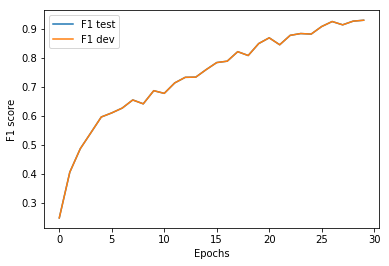

In [6]:
plt.plot(cnn_blstm.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

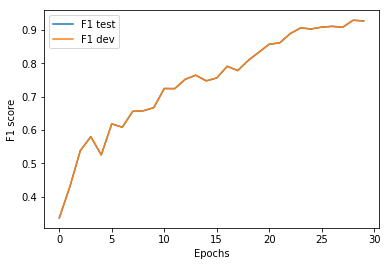

In [6]:
plt.plot(cnn_blstm.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# Label distribution

In [8]:
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()

category_count = {"B\n": 0, "I\n":0, "O\n": 0, "U\n":0, "L\n":0}
total_count = 0

for sentence in cnn_blstm.testSentences:
    for word in sentence:
        if word[1] in category_count.keys():
            category_count[word[1]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))            

B: 3.33%
I: 2.11%
O: 88.88%
U: 2.52%
L: 3.17%
